In [1]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation , Embedding, GlobalMaxPooling1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14463902100409680022
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3157314764
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13497413347889092819
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
dataset_dir = 'dataset\emotion_dataset.csv'
glove_dir = 'glove\glove.twitter.27B.100d.txt'

In [4]:
nltk_stop_words = list(stopwords.words('english'))

In [5]:
dataset = pd.read_csv(dataset_dir, sep=',', index_col=0)
dataset.head()

,emotion,text
0,anger,fuckin'm transtelecom
1,anger,Working But it's Fridaaaayyyyy
2,anger,Packing I don't like it..
3,anger,I tried to dye my hair and all i got was a blo...
4,anger,&quot;locked up abroad&quot; makes bein half b...


In [6]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,emotion,text
0,sadness,So Cal Dachshund Rescue found a home for my fo...
1,anger,My grandmother's brother had taken active part...
2,neutral,@iminditch yesh and that potato guy is online....
3,sadness,Sadly I am bprohibiting myself from tweeting t...
4,worry,@shondarhimes Sure you will tweet about this w...


In [7]:
emotion = np.array(dataset['emotion'])

In [8]:
class_values = dataset['emotion'].unique()
print(class_values)

['sadness' 'anger' 'neutral' 'worry' 'surprise' 'happiness' 'hate']


In [9]:
dataset.groupby('emotion')['text'].count()

emotion
anger        1000
happiness    1000
hate         1000
neutral      1000
sadness      1000
surprise     1000
worry        1000
Name: text, dtype: int64

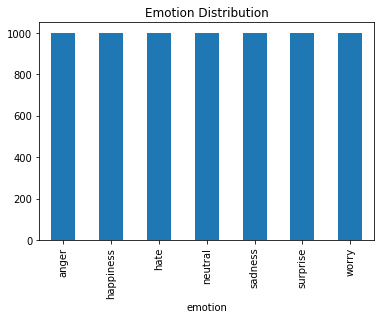

In [10]:
dataset.groupby('emotion')['text'].count().plot(kind='bar' , title= 'Emotion Distribution')

In [11]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
#     # Remove - & '
#     word = re.sub(r'(-|\')', '', word)
    return word


In [12]:
emotion

array(['sadness', 'anger', 'neutral', ..., 'sadness', 'anger', 'neutral'],
      dtype=object)

In [13]:
def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


In [14]:
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' smile ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' laugh ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' love ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' affection ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' sad ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' cry ', tweet)
    return tweet

In [15]:
def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    #HTML removed
    #html_process = BS(tweet, 'html.parser')
    #tweet = html_process.get_tweet()
    
    tweet = re.sub(r"what's", "what is ", tweet)
    tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    tweet = re.sub(r"n't", " not ", tweet)
    tweet = re.sub(r"i'm", "i am ", tweet)
    tweet = re.sub(r"\'re", " are ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', ' ', tweet)
    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)
    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)
    # Strip space, " and ' from tweet
    #tweet = tweet.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)
    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    # Striping numbers from the tweet
    tweet = re.sub(r'\d+', '', tweet)
    
    tweet = re.sub(r",", " ", tweet)
    tweet = re.sub(r"\.", " ", tweet)
    tweet = re.sub(r"!", " ! ", tweet)
    tweet = re.sub(r"\/", " ", tweet)
    tweet = re.sub(r"\^", " ^ ", tweet)
    tweet = re.sub(r"\+", " + ", tweet)
    tweet = re.sub(r"\-", " - ", tweet)
    tweet = re.sub(r"\=", " = ", tweet)
    tweet = re.sub(r"'", " ", tweet)
    
    
    words = tweet.split()
    
    stemmer = SnowballStemmer('english')

    #Removing Stop Words and Stemming the Words
    for word in words:
        word = preprocess_word(word)
        if word not in nltk_stop_words and len(word)> 2:
            if is_valid_word(word):
                stemmed_words = stemmer.stem(word)
                processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [16]:
dataset['text'] = dataset['text'].map(lambda x: preprocess_tweet(x))
dataset.head()

,emotion,text
0,sadness,cal dachshund rescue found home foster pup max...
1,anger,grandmother brother taken active part resistan...
2,neutral,yesh potato guy online hes live
3,sadness,sadly bprohibiting tweeting tonight sorry
4,worry,sure tweet back news abuzz knight leaving toda...


In [17]:
def plot_model(history):
    # Plot training & validation accuracy values
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [18]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(emotion)

print(label_encoder.classes_)

label_OneHotEncoder = OneHotEncoder()
encoded_label = label_OneHotEncoder.fit_transform(encoded_label.reshape(-1,1)).toarray()

['anger' 'happiness' 'hate' 'neutral' 'sadness' 'surprise' 'worry']


In [19]:
vocabulary_size = 10000
input_length = 100

In [20]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])
data = pad_sequences(sequences, maxlen = input_length)

In [21]:
train_data, test_data, train_label, test_label = train_test_split(data, encoded_label, test_size = 0.2)

In [22]:
num_classes = len(class_values)
validation_split = 0.1

In [23]:
output_dim = 1000
dense_input = 1000

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 32
l2_lstm_units = 64

validation_split = 0.2
epochs = 20

callback_patience = 3

In [24]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [25]:
model = Sequential()

model.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model.add(Dense(dense_input, activation='tanh'))

model.add(LSTM(l1_lstm_units, dropout = l1_dropout, recurrent_dropout = l1_recurrent_dropout, 
                             return_sequences = True, activation='tanh'))
model.add(LSTM(l2_lstm_units, dropout = l2_dropout, recurrent_dropout = l2_recurrent_dropout, 
                             return_sequences = False, activation='tanh'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 1000)         10000000  
_________________________________________________________________
dense (Dense)                (None, 100, 1000)         1001000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 32)           132224    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 11,158,511
Trainable params: 11,158,511
Non-trainable params: 0
_________________________________________________________________


D:\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4480 samples, validate on 1120 samples
Epoch 1/20
4480/4480 [==============================] - 114s 25ms/step - loss: 0.3834 - acc: 0.8629 - val_loss: 0.3577 - val_acc: 0.8694
Epoch 2/20
4480/4480 [==============================] - 110s 24ms/step - loss: 0.3091 - acc: 0.8801 - val_loss: 0.3762 - val_acc: 0.8610
Epoch 3/20
4480/4480 [==============================] - 113s 25ms/step - loss: 0.2248 - acc: 0.9069 - val_loss: 0.4177 - val_acc: 0.8506
Epoch 4/20
4480/4480 [==============================] - 115s 26ms/step - loss: 0.1654 - acc: 0.9357 - val_loss: 0.4781 - val_acc: 0.8353


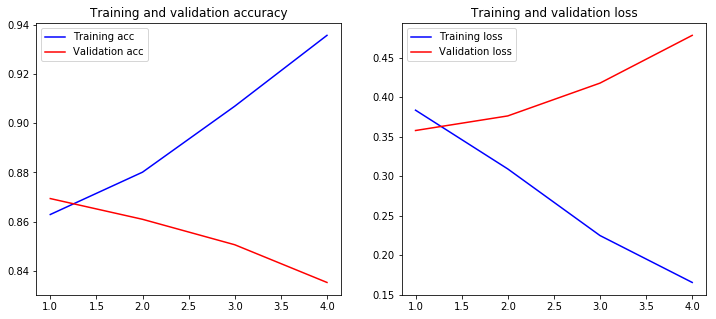

In [27]:
history = model.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, 
                    shuffle = True, callbacks = callback)

plot_model(history)

In [28]:
model.evaluate(test_data, test_label, verbose = 1)

1400/1400 [==============================] - 12s 8ms/step


[0.4690259427683694, 0.8375510246413095]

In [29]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 5

pool_size = 4

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

In [30]:
model_conv = Sequential()

model_conv.add(Embedding(vocabulary_size, output_dim, input_length = input_length, trainable=False))
model_conv.add(Dropout(dropout))
model_conv.add(Dense(output_dim, activation='tanh'))

model_conv.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, activation = 'relu'))
model_conv.add(MaxPooling1D(pool_size = pool_size))

model_conv.add(LSTM(l1_lstm_units , dropout = l1_dropout, return_sequences=True, activation='tanh'))
model_conv.add(LSTM(l2_lstm_units , dropout = l2_dropout, return_sequences=False, activation='relu'))

model_conv.add(Dense(num_classes, activation='softmax'))
model_conv.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [31]:
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 100, 100)          10100     
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 100)           50100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 64)            42240     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
__________

Train on 4480 samples, validate on 1120 samples
Epoch 1/20
4480/4480 [==============================] - 36s 8ms/step - loss: 0.4078 - acc: 0.8578 - val_loss: 0.4007 - val_acc: 0.8599
Epoch 2/20
4480/4480 [==============================] - 26s 6ms/step - loss: 0.4010 - acc: 0.8591 - val_loss: 0.3963 - val_acc: 0.8602
Epoch 3/20
4480/4480 [==============================] - 26s 6ms/step - loss: 0.3970 - acc: 0.8600 - val_loss: 0.3954 - val_acc: 0.8608
Epoch 4/20
4480/4480 [==============================] - 27s 6ms/step - loss: 0.3952 - acc: 0.8607 - val_loss: 0.3925 - val_acc: 0.8615
Epoch 5/20
4480/4480 [==============================] - 25s 6ms/step - loss: 0.3933 - acc: 0.8614 - val_loss: 0.3935 - val_acc: 0.8619
Epoch 6/20
4480/4480 [==============================] - 26s 6ms/step - loss: 0.3910 - acc: 0.8623 - val_loss: 0.3892 - val_acc: 0.8629
Epoch 7/20
4480/4480 [==============================] - 24s 5ms/step - loss: 0.3878 - acc: 0.8630 - val_loss: 0.3886 - val_acc: 0.8626
Epoch 8

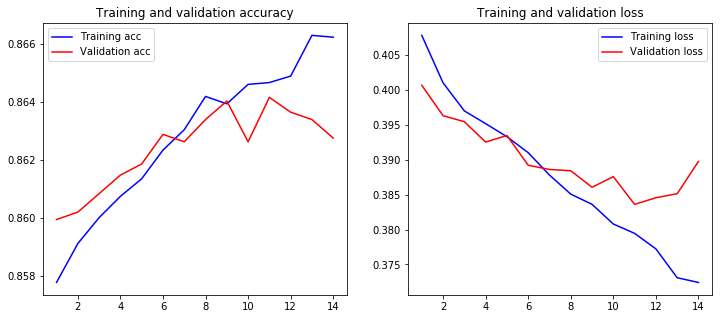

In [32]:
history = model_conv.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, 
                         shuffle = True, callbacks = callback)

plot_model(history)

In [33]:
embeddings_index = dict()
f = open(glove_dir, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [34]:
embedding_matrix = np.zeros((vocabulary_size, output_dim))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [35]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 4

pool_size = 5

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

In [36]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, output_dim, input_length = input_length, 
                          weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(dropout))

model_glove.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, 
                       activation='tanh'))
model_glove.add(MaxPooling1D(pool_size = pool_size))

model_glove.add(LSTM(l1_lstm_units , dropout = l1_dropout,
                     return_sequences=True, activation='tanh'))
model_glove.add(LSTM(l2_lstm_units , dropout = l2_dropout,
                     return_sequences=False , activation='tanh'))

model_glove.add(Dense(7, activation='softmax'))

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
model_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 97, 100)           40100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 19, 64)            42240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 231       
Total para

Train on 4480 samples, validate on 1120 samples
Epoch 1/20
4480/4480 [==============================] - 20s 4ms/step - loss: 0.3931 - acc: 0.8605 - val_loss: 0.3757 - val_acc: 0.8649
Epoch 2/20
4480/4480 [==============================] - 18s 4ms/step - loss: 0.3693 - acc: 0.8658 - val_loss: 0.3613 - val_acc: 0.8677
Epoch 3/20
4480/4480 [==============================] - 18s 4ms/step - loss: 0.3585 - acc: 0.8681 - val_loss: 0.3571 - val_acc: 0.8688
Epoch 4/20
4480/4480 [==============================] - 18s 4ms/step - loss: 0.3487 - acc: 0.8703 - val_loss: 0.3538 - val_acc: 0.8695
Epoch 5/20
4480/4480 [==============================] - 18s 4ms/step - loss: 0.3453 - acc: 0.8710 - val_loss: 0.3518 - val_acc: 0.8712
Epoch 6/20
4480/4480 [==============================] - 18s 4ms/step - loss: 0.3380 - acc: 0.8726 - val_loss: 0.3543 - val_acc: 0.8705
Epoch 7/20
4480/4480 [==============================] - 19s 4ms/step - loss: 0.3336 - acc: 0.8744 - val_loss: 0.3527 - val_acc: 0.8708
Epoch 8

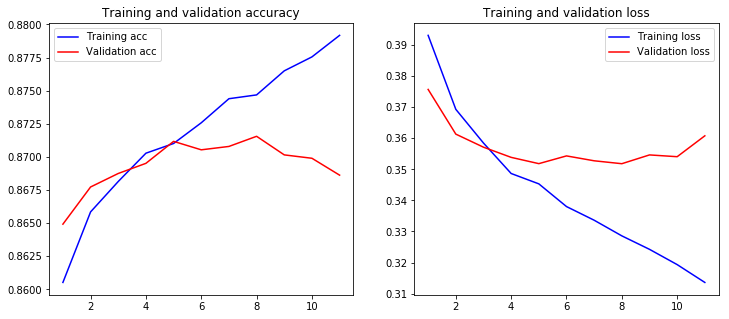

In [38]:
history = model_glove.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, 
                          shuffle = True, callbacks = callback)

plot_model(history)

In [39]:
model_glove.evaluate(test_data, test_label, verbose = 1)

1400/1400 [==============================] - 3s 2ms/step


[0.3608707627228328, 0.8675510365622384]

In [40]:
model_conv.predict(test_data[0:1])

array([[0.08448397, 0.19723374, 0.15780073, 0.10385689, 0.13393189,
        0.1542532 , 0.16843952]], dtype=float32)

In [41]:
test_data.shape

(1400, 100)

In [42]:
test_data[0].shape

(100,)

In [43]:
test_text = 'I was happy but then I am not happy'
test_text = pd.Series(test_text)

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen = input_length)

In [44]:
data.shape

(1, 100)

In [45]:
data

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 125, 125]])

In [46]:
label_encoder.classes_[np.argmax(model.predict(data))]

'happiness'

In [47]:
label_encoder.classes_[np.argmax(model_conv.predict(data))]

'neutral'

In [48]:
label_encoder.classes_[np.argmax(model_glove.predict(data))]

'neutral'

In [49]:
print(label_encoder.classes_)

['anger' 'happiness' 'hate' 'neutral' 'sadness' 'surprise' 'worry']
